In [1]:
!pip install -U segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 32.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 70.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: 

In [7]:
import os
import pandas as pd
from PIL import Image



# Vérifier nombre d'images
print("Train images:", len(os.listdir("/kaggle/input/wound-segmentation-images/data_wound_seg/train_images")))
print("Train masks:", len(os.listdir("/kaggle/input/wound-segmentation-images/data_wound_seg/train_masks")))
print("Test images:", len(os.listdir("/kaggle/input/wound-segmentation-images/data_wound_seg/test_images")))
print("Test masks:", len(os.listdir("/kaggle/input/wound-segmentation-images/data_wound_seg/test_masks")))

# # Exemple de chargement d’image + masque
# img = Image.open("data_wound_seg/train_images/xxx.jpg")
# mask = Image.open("data_wound_seg/train_masks/xxx.png")
# img.show()

# mask.show()


Train images: 2208
Train masks: 2208
Test images: 552
Test masks: 552


In [8]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms

class WoundSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, img_transform=None, mask_transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform
        self.images = sorted(os.listdir(img_dir))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.img_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name.replace(".jpg", ".png"))

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        if self.img_transform:
            image = self.img_transform(image)

        if self.mask_transform:
            mask = self.mask_transform(mask)
            mask = (mask > 0.5).float()   # important : masque binaire final !

        return image, mask


In [9]:
from torch.utils.data import DataLoader
from torchvision import transforms

img_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor()
])

mask_transform = transforms.Compose([
    transforms.Resize((512, 512), interpolation=Image.NEAREST),
    transforms.ToTensor()
])

In [10]:
train_dataset = WoundSegDataset(
    "/kaggle/input/wound-segmentation-images/data_wound_seg/train_images",
    "/kaggle/input/wound-segmentation-images/data_wound_seg/train_masks",
    img_transform=img_transform,
    mask_transform=mask_transform
)

test_dataset = WoundSegDataset(
    "/kaggle/input/wound-segmentation-images/data_wound_seg/test_images",
    "/kaggle/input/wound-segmentation-images/data_wound_seg/test_masks",
    img_transform=img_transform,
    mask_transform=mask_transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [11]:
import torch
from torchmetrics.classification import BinaryAccuracy
import segmentation_models_pytorch as smp
import numpy as np


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [12]:
model = smp.DeepLabV3Plus(
    encoder_name="resnet101",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
    activation=None,
    decoder_dropout=0.3
).to(device)


In [13]:
criterion = smp.losses.DiceLoss(mode='binary')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# === Early stopping ===
best_val_loss = float("inf")
patience = 5      # nombre d’epochs sans amélioration avant arrêt
wait = 0          # compteur

In [14]:
accuracy_metric = BinaryAccuracy().to(device)

# === Boucle d'entraînement ===
for epoch in range(50):

    model.train()
    train_loss = 0.0
    train_acc = 0.0
    count = 0

    for imgs, masks in train_loader:
        imgs, masks = imgs.to(device), masks.to(device)

        preds = model(imgs)                    # logits
        loss = criterion(preds, masks)         # pas de sigmoid ici !!

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # === Accuracy ===
        preds_prob = torch.sigmoid(preds)      # sigmoid ici
        preds_bin = (preds_prob > 0.5).float()

        acc = accuracy_metric(preds_bin, masks)

        train_loss += loss.item()
        train_acc += acc.item()
        count += 1

    train_loss /= count
    train_acc /= count

    # === VALIDATION ===
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    val_count = 0

    with torch.no_grad():
        for imgs, masks in val_loader:
            imgs, masks = imgs.to(device), masks.to(device)

            preds = model(imgs)                # logits
            loss = criterion(preds, masks)

            # Accuracy validation
            preds_prob = torch.sigmoid(preds)
            preds_bin = (preds_prob > 0.5).float()

            acc = accuracy_metric(preds_bin, masks)

            val_loss += loss.item()
            val_acc += acc.item()
            val_count += 1

    val_loss /= val_count
    val_acc /= val_count

    print(f"Epoch [{epoch+1}] | "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # === EARLY STOPPING ===
    if val_loss < best_val_loss:
        print(f"🔥 New best model at epoch {epoch+1} (val_loss={val_loss:.4f}) — model saved!")
        best_val_loss = val_loss
        wait = 0
        torch.save(model.state_dict(), "best_unet.pth")
    else:
        wait += 1
        print(f"⏳ No improvement. patience: {wait}/{patience}")

        if wait >= patience:
            print("🛑 Early stopping triggered — training stopped.")
            break


Epoch [1] | Train Loss: 0.5527 | Train Acc: 0.9380 | Val Loss: 0.4946 | Val Acc: 0.9948
🔥 New best model at epoch 1 (val_loss=0.4946) — model saved!
Epoch [2] | Train Loss: 0.2400 | Train Acc: 0.9850 | Val Loss: 0.2607 | Val Acc: 0.9950
🔥 New best model at epoch 2 (val_loss=0.2607) — model saved!
Epoch [3] | Train Loss: 0.1747 | Train Acc: 0.9876 | Val Loss: 0.1905 | Val Acc: 0.9964
🔥 New best model at epoch 3 (val_loss=0.1905) — model saved!
Epoch [4] | Train Loss: 0.1343 | Train Acc: 0.9902 | Val Loss: 0.1960 | Val Acc: 0.9958
⏳ No improvement. patience: 1/5
Epoch [5] | Train Loss: 0.1187 | Train Acc: 0.9908 | Val Loss: 0.1539 | Val Acc: 0.9964
🔥 New best model at epoch 5 (val_loss=0.1539) — model saved!
Epoch [6] | Train Loss: 0.1070 | Train Acc: 0.9919 | Val Loss: 0.1537 | Val Acc: 0.9963
🔥 New best model at epoch 6 (val_loss=0.1537) — model saved!
Epoch [7] | Train Loss: 0.1012 | Train Acc: 0.9919 | Val Loss: 0.1488 | Val Acc: 0.9962
🔥 New best model at epoch 7 (val_loss=0.1488) —

KeyboardInterrupt: 

In [16]:
from torchmetrics.classification import BinaryJaccardIndex, BinaryF1Score, BinaryPrecision, BinaryRecall, BinaryAccuracy
import torch

metrics = {
    "accuracy": BinaryAccuracy().to(device),
    "dice": BinaryF1Score().to(device),
    "precision": BinaryPrecision().to(device),
    "recall": BinaryRecall().to(device),
    "iou": BinaryJaccardIndex().to(device)
}

In [17]:
def evaluate_model(model, dataloader, device):
    model.eval()

    results = {
        "accuracy": 0,
        "dice": 0,
        "precision": 0,
        "recall": 0,
        "iou": 0
    }

    count = 0

    with torch.no_grad():
        for imgs, masks in dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            logits = model(imgs)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()

            results["accuracy"] += metrics["accuracy"](preds, masks).item()
            results["dice"] += metrics["dice"](preds, masks).item()
            results["precision"] += metrics["precision"](preds, masks).item()
            results["recall"] += metrics["recall"](preds, masks).item()
            results["iou"] += metrics["iou"](preds, masks).item()

            count += 1

    for key in results:
        results[key] /= count

    return results


In [18]:
results = evaluate_model(model, val_loader, device)

print("\n===== METRIQUES FINALES =====")
print(f"Accuracy  : {results['accuracy']:.4f}")
print(f"Dice      : {results['dice']:.4f}")
print(f"Precision : {results['precision']:.4f}")
print(f"Recall    : {results['recall']:.4f}")
print(f"IoU       : {results['iou']:.4f}")



===== METRIQUES FINALES =====
Accuracy  : 0.9963
Dice      : 0.8668
Precision : 0.8289
Recall    : 0.9165
IoU       : 0.7687


In [19]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def show_overlay(img, mask_true, mask_pred):
    """
    img : tensor [C,H,W]
    mask_true : tensor [H,W]
    mask_pred : tensor [H,W]
    """

    img = img.permute(1,2,0).cpu().numpy()
    mask_true = mask_true.cpu().numpy()
    mask_pred = mask_pred.cpu().numpy()

    # couleurs
    overlay_true = img.copy()
    overlay_pred = img.copy()

    # masque réel = rouge
    overlay_true[mask_true==1] = [1, 0, 0]

    # masque prédit = vert
    overlay_pred[mask_pred==1] = [0, 1, 0]

    plt.figure(figsize=(12,5))

    plt.subplot(1,3,1)
    plt.imshow(img)
    plt.title("Image originale")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.imshow(overlay_true)
    plt.title("Masque réel (rouge)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(overlay_pred)
    plt.title("Masque prédit (vert)")
    plt.axis("off")

    plt.show()


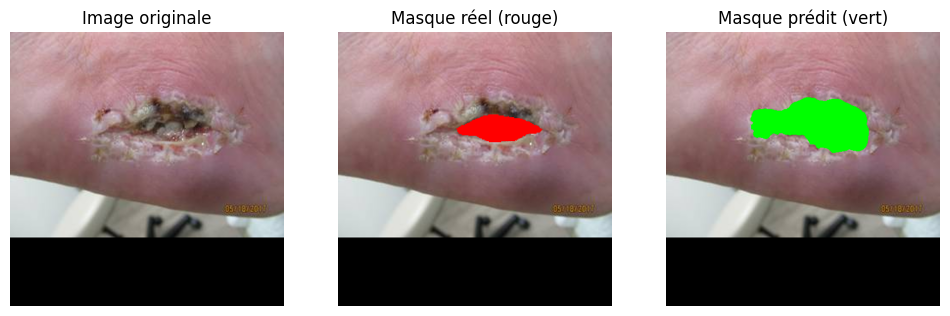

In [20]:
img, mask = test_dataset[3]
pred = (torch.sigmoid(model(img.unsqueeze(0).to(device))) > 0.5).float()[0,0].cpu()

show_overlay(img, mask[0], pred)


In [21]:
import cv2

def show_contours(img, mask_true, mask_pred):
    img_np = (img.permute(1,2,0).cpu().numpy()*255).astype(np.uint8)
    true_np = (mask_true.cpu().numpy()*255).astype(np.uint8)
    pred_np = (mask_pred.cpu().numpy()*255).astype(np.uint8)

    # trouver les contours
    contours_true, _ = cv2.findContours(true_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_pred, _ = cv2.findContours(pred_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    contour_img = img_np.copy()

    # rouge = mask réel
    cv2.drawContours(contour_img, contours_true, -1, (255,0,0), 2)

    # vert = prédiction
    cv2.drawContours(contour_img, contours_pred, -1, (0,255,0), 2)

    plt.figure(figsize=(6,6))
    plt.imshow(contour_img)
    plt.title("Contours (Rouge=Réel, Vert=Prédit)")
    plt.axis("off")
    plt.show()


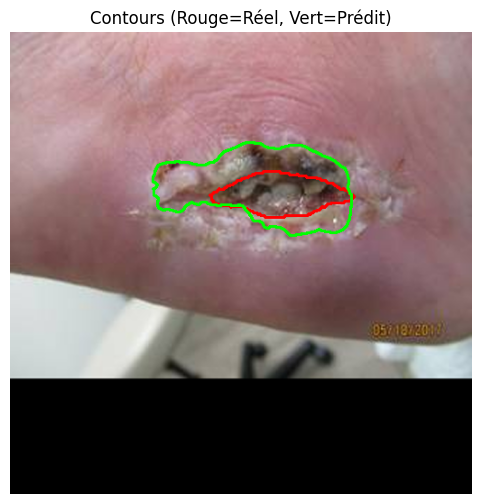

In [22]:
show_contours(img, mask[0], pred)

In [23]:
def show_error_heatmap(img, mask_true, mask_pred):
    img_np = img.permute(1,2,0).cpu().numpy()

    error = np.abs(mask_pred.cpu().numpy() - mask_true.cpu().numpy())

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.imshow(img_np)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(img_np, alpha=0.6)
    plt.imshow(error, cmap="jet", alpha=0.4)
    plt.title("Erreur (rouge = erreur forte)")
    plt.axis("off")

    plt.show()


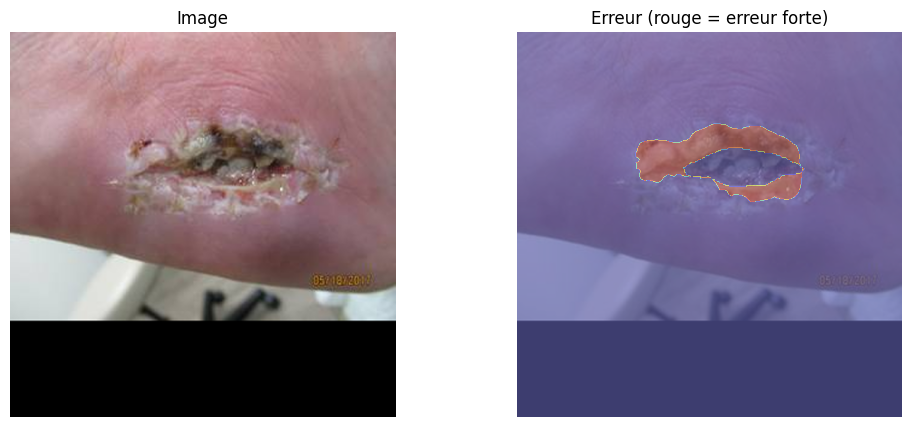

In [24]:
show_error_heatmap(img, mask[0], pred)

In [25]:
def show_tp_fp_fn(img, mask_true, mask_pred):
    img = img.permute(1,2,0).cpu().numpy()

    m = mask_true.cpu().numpy()
    p = mask_pred.cpu().numpy()

    TP = (p==1) & (m==1)
    FP = (p==1) & (m==0)
    FN = (p==0) & (m==1)

    overlay = img.copy()

    overlay[TP] = [0, 1, 0]   # vert
    overlay[FP] = [0, 0, 1]   # bleu
    overlay[FN] = [1, 0, 0]   # rouge

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.title("TP (vert) / FP (bleu) / FN (rouge)")
    plt.axis("off")
    plt.show()


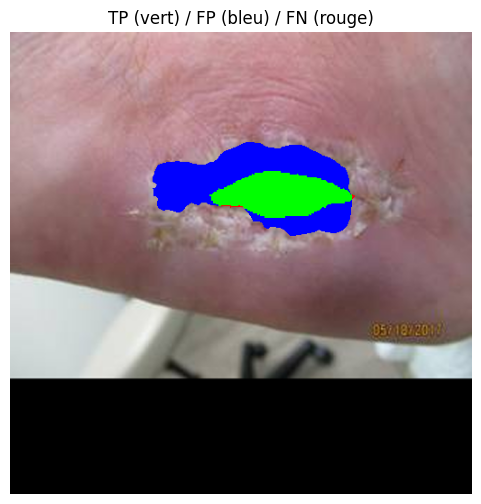

In [26]:
show_tp_fp_fn(img, mask[0], pred)

In [34]:
import matplotlib.pyplot as plt
import torch
import numpy as np

def show_examples(model, dataset, device, n=10):
    model.eval()

    plt.figure(figsize=(15, n*3))

    with torch.no_grad():
        for i in range(n):
            img, mask = dataset[i]
            img_in = img.unsqueeze(0).to(device)

            # prédiction
            prob = torch.sigmoid(model(img_in))[0,0].cpu()
            pred = (prob > 0.5).float()

            img_np = img.permute(1,2,0).cpu().numpy()
            mask_np = mask[0].cpu().numpy()
            pred_np = pred.cpu().numpy()

            # ---- PLOT ----
            plt.subplot(n, 3, i*3+1)
            plt.imshow(img_np)
            plt.title(f"Image {i}")
            plt.axis("off")

            plt.subplot(n, 3, i*3+2)
            plt.imshow(mask_np, cmap="gray")
            plt.title("Masque réel")
            plt.axis("off")

            plt.subplot(n, 3, i*3+3)
            plt.imshow(pred_np, cmap="gray")
            plt.title("Masque prédit")
            plt.axis("off")

    plt.tight_layout()
    plt.show()


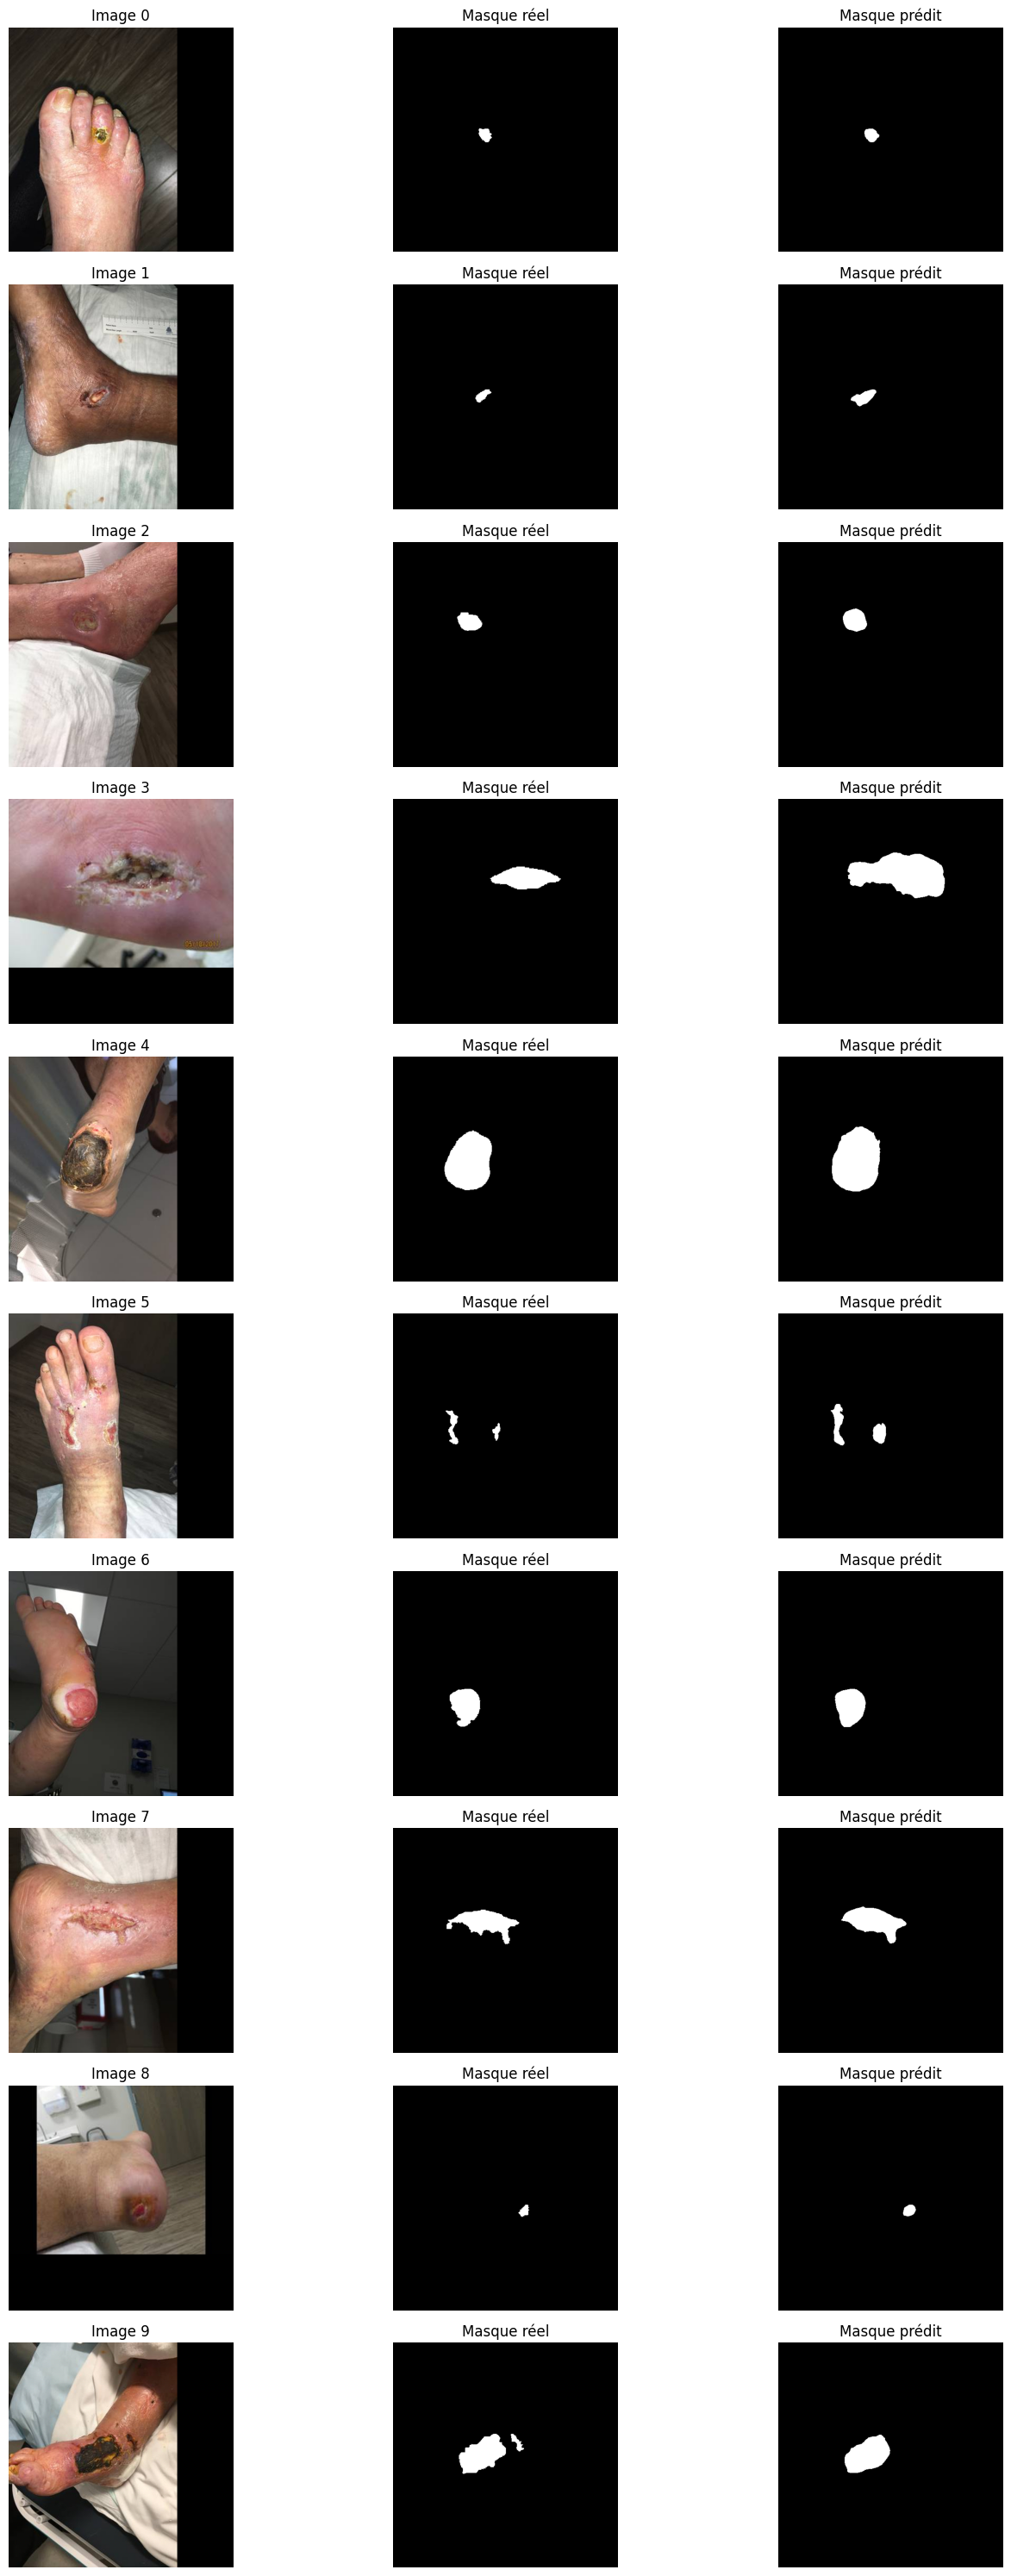

In [35]:
show_examples(model, test_dataset, device, n=10)

In [15]:
from torchmetrics.classification import BinaryJaccardIndex

iou = BinaryJaccardIndex().to(device)
model.eval()

for imgs, masks in val_loader:
    imgs, masks = imgs.to(device), masks.to(device)

    # Binariser le masque ici
    masks = (masks > 0.3).float()

    preds = torch.sigmoid(model(imgs)) > 0.3

    print("IoU:", iou(preds, masks).item())

    surface = preds.sum().item()
    print(f"Surface moyenne : {surface} pixels")



IoU: 0.6314846277236938
Surface moyenne : 46588 pixels
IoU: 0.722168505191803
Surface moyenne : 21553 pixels
IoU: 0.7590005993843079
Surface moyenne : 38430 pixels
IoU: 0.8231188058853149
Surface moyenne : 24117 pixels
IoU: 0.7580969333648682
Surface moyenne : 20618 pixels
IoU: 0.6582559943199158
Surface moyenne : 30041 pixels
IoU: 0.7993106842041016
Surface moyenne : 10483 pixels
IoU: 0.8757986426353455
Surface moyenne : 21574 pixels
IoU: 0.6338208317756653
Surface moyenne : 25210 pixels
IoU: 0.8350679278373718
Surface moyenne : 34093 pixels
IoU: 0.7230967879295349
Surface moyenne : 29019 pixels
IoU: 0.6514306664466858
Surface moyenne : 26073 pixels
IoU: 0.853398323059082
Surface moyenne : 38310 pixels
IoU: 0.8582871556282043
Surface moyenne : 27195 pixels
IoU: 0.7613463401794434
Surface moyenne : 6312 pixels
IoU: 0.8712465763092041
Surface moyenne : 21182 pixels
IoU: 0.6619953513145447
Surface moyenne : 18554 pixels
IoU: 0.7616847157478333
Surface moyenne : 23235 pixels
IoU: 0.780649

In [27]:
import matplotlib.pyplot as plt
import torch
import math

def show_first_predictions_with_probs(model, dataset, device, n=10, cols=3):
    """
    Affiche n images (par défaut les premières) avec :
    - Image originale
    - Masque réel
    - Prédiction (probabilités)
    - Prédiction binaire (>0.5)
    Disposées sur plusieurs lignes pour une taille lisible.
    """

    model.eval()
    rows = math.ceil(n / cols)
    fig, axes = plt.subplots(rows, cols*4, figsize=(cols*12, rows*4))
    axes = axes.flatten() if n > 1 else [axes]

    for i in range(n):
        img, mask = dataset[i]
        img_input = img.unsqueeze(0).to(device)

        with torch.no_grad():
            pred_prob = torch.sigmoid(model(img_input))
            pred_bin = (pred_prob > 0.5).float()

        # conversions CPU
        img_cpu = img.detach().permute(1,2,0).cpu()
        mask_cpu = mask[0].detach().cpu()
        prob_cpu = pred_prob[0][0].detach().cpu()
        bin_cpu = pred_bin[0][0].detach().cpu()

        # position de départ de la ligne i
        start = i * 4

        axes[start].imshow(img_cpu)
        axes[start].set_title(f"#{i} – Image")
        axes[start].axis('off')

        axes[start+1].imshow(mask_cpu, cmap='gray')
        axes[start+1].set_title("Masque réel")
        axes[start+1].axis('off')

        axes[start+2].imshow(prob_cpu, cmap='gray')
        axes[start+2].set_title("Prédiction (proba)")
        axes[start+2].axis('off')

        axes[start+3].imshow(bin_cpu, cmap='gray')
        axes[start+3].set_title("Prédiction (binaire)")
        axes[start+3].axis('off')

    # masquer les cases vides
    for ax in axes[n*4:]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


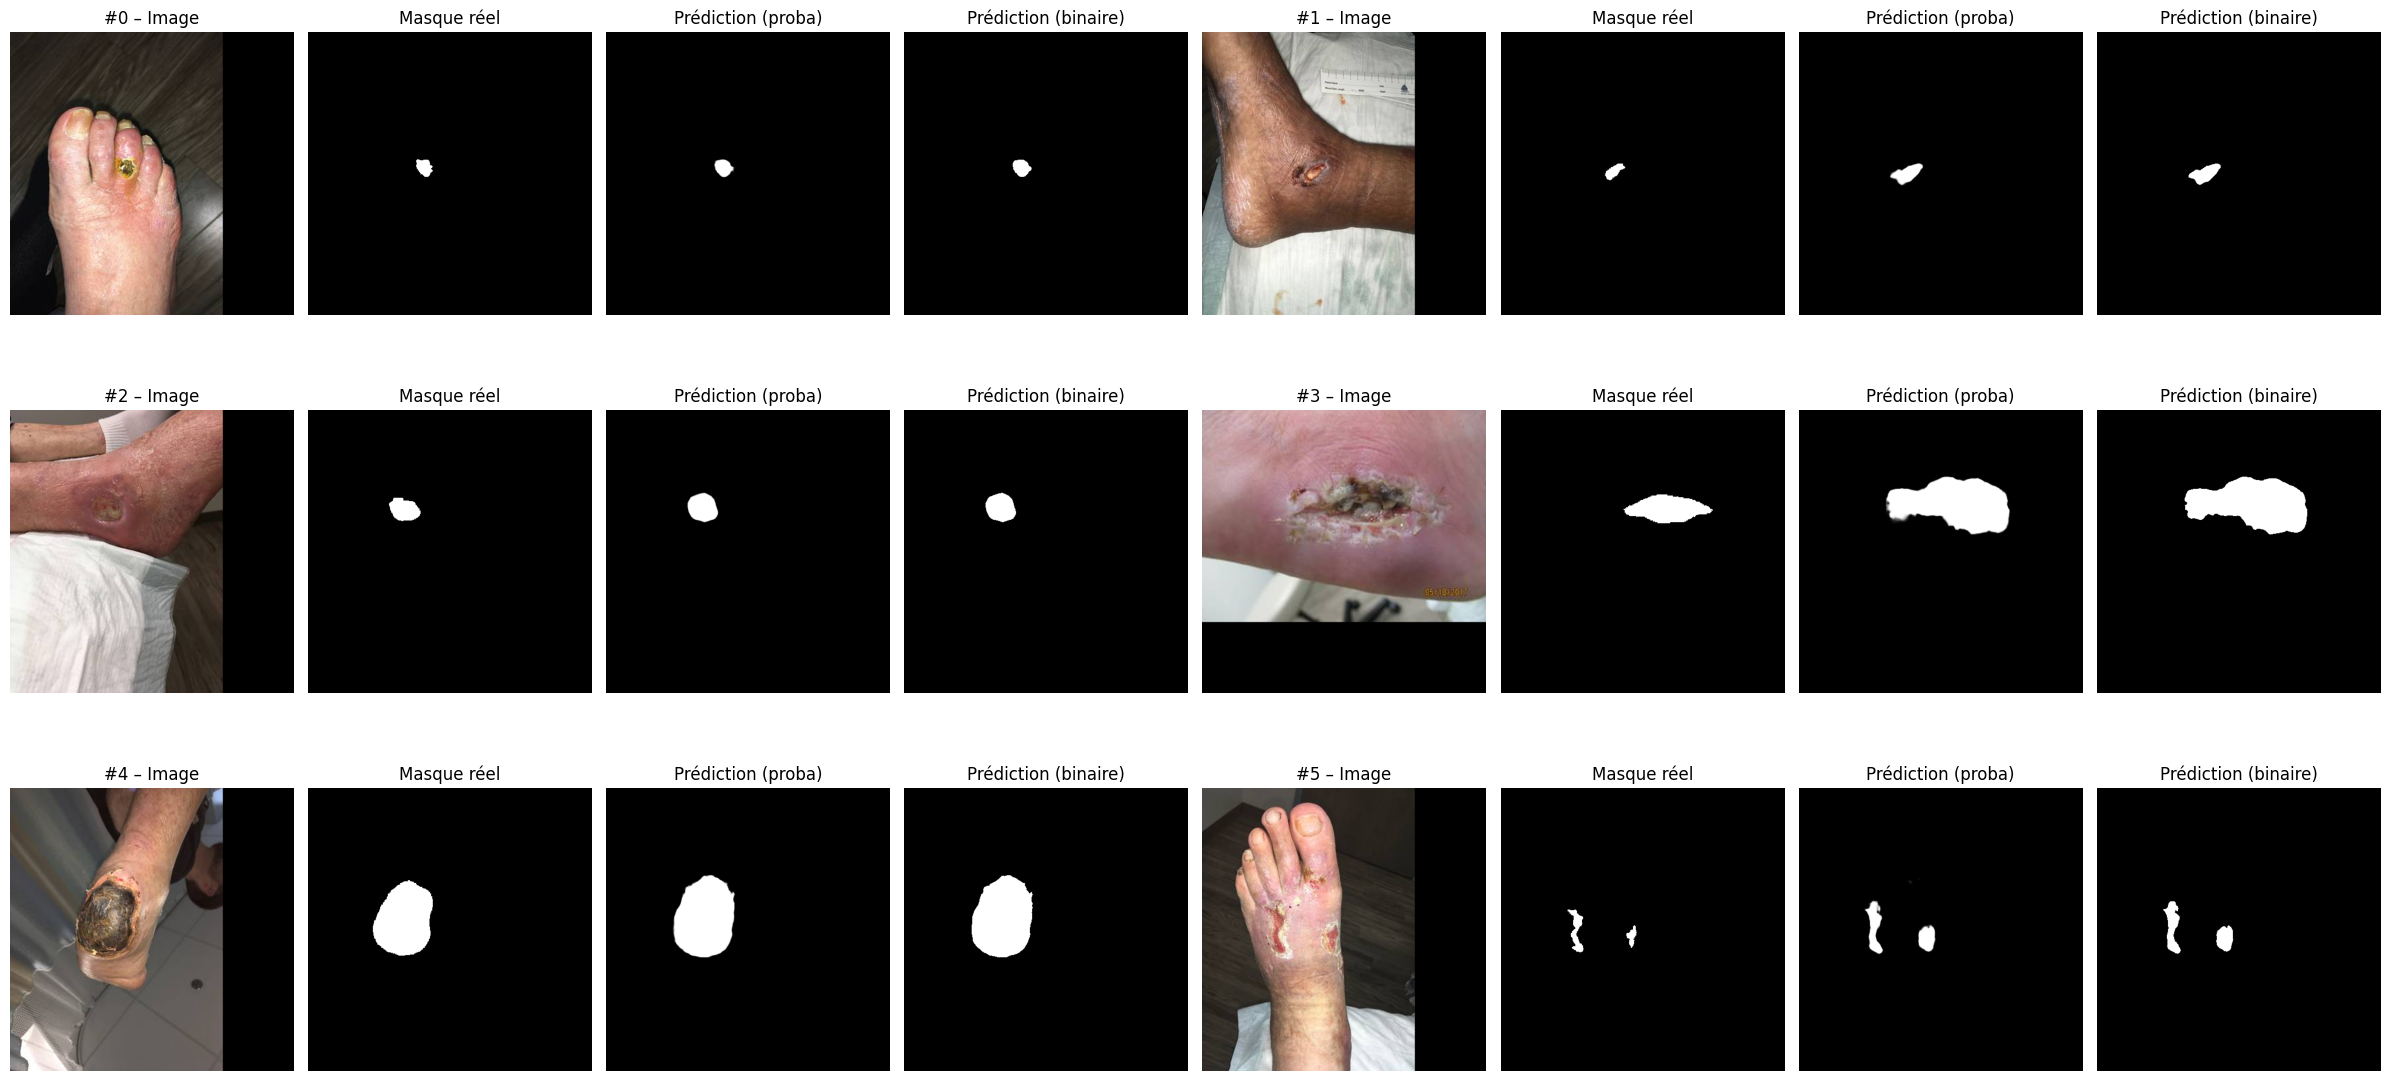

In [28]:
show_first_predictions_with_probs(model, test_dataset, device, n=6, cols=2)


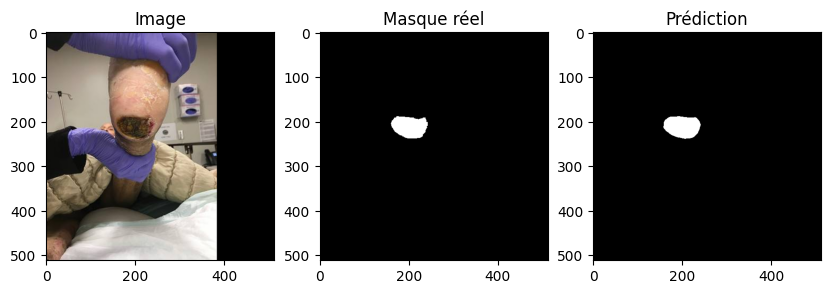

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1,3,1); plt.imshow(imgs[6].detach().permute(1,2,0).cpu()); plt.title("Image")
plt.subplot(1,3,2); plt.imshow(masks[6][0].detach().cpu(), cmap='gray'); plt.title("Masque réel")
plt.subplot(1,3,3); plt.imshow(preds[6][0].detach().cpu(), cmap='gray'); plt.title("Prédiction")
plt.show()
